<a href="https://colab.research.google.com/github/georgeliu1998/keras_model_tuning/blob/master/keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import sklearn
import pickle
from time import time
import importlib # for dynamic class instantiation from a string

from sklearn.model_selection import StratifiedKFold, cross_val_score
#from sklearn.preprocessing import StandardScaler

import xgboost as xgb


from keras.models import Sequential
from keras.layers import Dense
#from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import to_categorical

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Using TensorFlow backend.


In [0]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

seed = np.random.RandomState(6)

In [3]:
# Mount gdrive 
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
df = pd.read_csv("/content/gdrive/My Drive/pima-indians-diabetes.csv", header=None)
df.head()

,0,1,2,3,4,5,6,7,8
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
# Get the features and labels as np arrays
X, y = df.values[:, 0:8], df.values[:, 8]
print(X.shape, y.shape)

(768, 8) (768,)


In [6]:
# Get baseline accuracy using XGBoost
t1 = time()
clf = xgb.XGBClassifier()
cv = StratifiedKFold(n_splits=3, random_state=seed)
scores = cross_val_score(clf, X, y, cv=cv)
t2 = time()
t = t2 - t1

print("Mean Accuracy: {:.2%}, Standard Deviation: {:.2%}".format(scores.mean(), scores.std()))
print("Time taken: {:.2f} seconds".format(t))

Mean Accuracy: 77.61%, Standard Deviation: 3.07%
Time taken: 0.12 seconds


In [0]:
class SequentialModel:
  """
  The base class for a Neural Networks model
  """
  
  def __init__(self, input_dim, num_layers, num_units, 
               activation, activation_out, 
               loss, initializer, optimizer, learning_rate, 
               metrics, epochs, batch_size, one_hot=False):
    """
    Params:
      input_dim: int, number of features
      num_layers: int, number of layers of the model (excluding the input layer)
      num_units: list, number of units in each layer(excluding the input layer)
      activation: str, activation function used in all layers except output
      activation_out: str, activation function used in output layer
      loss: str, loss functon
      initializer: str, kernel initializer
      optimizer: str, optimizer
      metrics: list of strings, metrics used
      epochs: int, number of epochs to train for
      batch_size: int, number of samples per batch
      one_hot: bool, whether one hot encoding is needed
    """
    self.input_dim = input_dim
    self.num_layers = num_layers
    self.num_units = num_units
    self.activation = activation
    self.activation_out = activation_out
    self.loss = loss
    self.initializer = initializer
    self.optimizer = optimizer
    self.learning_rate = learning_rate
    self.metrics = metrics
    self.epochs = epochs
    self.batch_size = batch_size
    self.one_hot = one_hot
    
    # Initialize the sequential model
    self.model = Sequential()
  
    
  def build_model(self):
    """
    Adds layers and compiles the model
    """
    # Ensure num_units tuple's length is the same as num_layers
    if self.num_layers != len(self.num_units):
      # Expand the list by repeating number of nodes except for last layer
      num_nodes, num_nodes_out = self.num_units[0], self.num_units[-1]
      self.num_units = [i for i in range(self.num_layers-1) for i in [num_nodes]]
      self.num_units.append(num_nodes_out) 
 
    # Loop thru all the layers
    for i in range(self.num_layers):
      # different layers should have different setups
      if i == 0: # input and first hidden layer
        self.model.add(Dense(units=self.num_units[i],
                             input_dim=self.input_dim,
                             kernel_initializer=self.initializer,
                             activation=self.activation)) 
      elif i+1 == self.num_layers: # output layer
        self.model.add(Dense(units=self.num_units[i],
                             kernel_initializer=self.initializer,
                             activation=self.activation_out))
      else: # hidden layers
        self.model.add(Dense(units=self.num_units[i],
                            kernel_initializer=self.initializer,
                            activation=self.activation))
    
    # Instantiate the optimizer class
    optimizer_class = getattr(importlib.import_module("keras.optimizers"), 
                             self.optimizer)
    self.optimizer = optimizer_class(lr=self.learning_rate)
    # Compile the model
    self.model.compile(loss=self.loss,
                       optimizer=self.optimizer,
                       metrics=self.metrics)
        
  
  def evaluate_model(self, X, y, n_splits=3):
    """
    Evaluates the model using cross-validation.
    
    Params:
      X: np.array, features
      y: np.array, labels
      n_splits: int, number of folds for the cross-validation
    Returns:
      mean_accuracy: float, the average accuracy based on the cross-validation.
    
    """
    score_lst = []
    t1 = time()
    
    print("Starting {}-fold cross-validation...".format(n_splits))
    
    kfold = StratifiedKFold(n_splits=n_splits, 
                            shuffle=True, 
                            random_state=seed)
    
    # Loop through the different folds
    for train_index, test_index in kfold.split(X, y):
      # Do one-hot encoding when needed
      if self.one_hot:
        y_one_hot = to_categorical(y)
      else:
        y_one_hot = y
        
      self.model.fit(X[train_index],
                     y_one_hot[train_index],
                     epochs=self.epochs,
                     batch_size=self.batch_size,
                     verbose=0)
        
      scores = self.model.evaluate(X[test_index],
                                   y_one_hot[test_index], 
                                   verbose=0)
            
      # The second item is accuracy
      score_lst.append(scores[1])

    t2 = time()
    t = t2 - t1
    # Convert time to mintues
    t /= 60

    print("Finished cross-valiation. Took {:.1f} mintues.".format(t))

    # Convert to np.array and calculate mean and sd
    score_lst = np.array(score_lst)
    mean_acc = score_lst.mean()
    sd_acc = score_lst.std()

    print("Mean Accuracy: {:.2%}, Standard Deviation: {:.2%}".format(mean_acc, sd_acc))
    return mean_acc

In [0]:
def get_defaults():
  """
  Returns a dict of default hyperparameter values
  """
  input_dim=8
  num_layers=2
  num_units=[8, 1]
  activation='relu'
  activation_out='sigmoid'
  loss='binary_crossentropy'
  initializer='random_uniform'
  optimizer='adam'
  learning_rate=0.001
  metrics=['accuracy']
  epochs=10
  batch_size=4
  one_hot=False
  
  defaults = {'input_dim': input_dim, 
              'num_layers': num_layers, 
              'num_units': num_units, 
              'activation': activation, 
              'activation_out': activation_out, 
              'loss': loss, 
              'initializer': initializer, 
              'optimizer': optimizer, 
              'learning_rate': learning_rate, 
              'metrics': metrics, 
              'epochs': epochs, 
              'batch_size': batch_size, 
              'one_hot': one_hot}
  
  return defaults

In [0]:
def build_test_model(param_dict):
  """
  Builds a Neural Network model using the given params and returns the 
  cross-validation accuracy
  
  Params:
    param_dict: dict - Python dict containing the tuning parameters and values
  
  Returns:
    result: float - percentage accuracy based on cross-validation
  
  """
  model = SequentialModel(input_dim=param_dict['input_dim'], 
                          num_layers=param_dict['num_layers'], 
                          num_units=param_dict['num_units'],
                          activation=param_dict['activation'], 
                          activation_out=param_dict['activation_out'], 
                          loss=param_dict['loss'], 
                          initializer=param_dict['initializer'], 
                          optimizer=param_dict['optimizer'], 
                          learning_rate=param_dict['learning_rate'], 
                          metrics=param_dict['metrics'], 
                          epochs=param_dict['epochs'], 
                          batch_size=param_dict['batch_size'], 
                          one_hot=param_dict['one_hot'])

  model.build_model()
  result = model.evaluate_model(X, y)
  
  return result

In [11]:
# Get baseline accuracy using defauls with the defined Neural Networks class  
defaults = get_defaults()
build_test_model(param_dict=defaults)

Starting 3-fold cross-validation...
Finished cross-valiation. Took 0.3 mintues.
Mean Accuracy: 70.32%, Standard Deviation: 2.83%


0.7032134935225333

In [0]:
def get_tuning_options(use_defaults=True, **kwargs):
  """
  Define tuning parameter and corresponding options
  
  Params:
    -----------------####################
  Returns:
    -----------------####################
  
  """ 
  tuning_options = {}
  
  for param, options in kwargs.items():
    tuning_options[param] = options 
  
  return tuning_options

In [13]:
num_units = [4, 8, 16, 32, 64]
num_layers = [2, 4, 8, 16, 32]
loss = ['binary_crossentropy', 'categorical_crossentropy', 'sparse_categorical_crossentropy']
initializer = ['random_uniform', 'random_normal', 'TruncatedNormal', 'glorot_normal', 'glorot_uniform']
learning_rate = [0.001, 0.002, 0.01, 0.1, 1]
optimizer = ['adam', 'adamax', 'adagrad', 'sgd', 'rmsprop']
epochs = [10, 20, 40, 80, 160]
batch_size = [1, 2, 4, 8, 16]


tuning_options = get_tuning_options(use_defaults=False,
                                    num_units=num_units, 
                                    num_layers=num_layers, 
                                    loss=loss, 
                                    initializer=initializer,
                                    learning_rate=learning_rate, 
                                    optimizer=optimizer, 
                                    epochs=epochs, 
                                    batch_size=batch_size)
tuning_options

{'batch_size': [1, 2, 4, 8, 16],
 'epochs': [10, 20, 40, 80, 160],
 'initializer': ['random_uniform',
  'random_normal',
  'TruncatedNormal',
  'glorot_normal',
  'glorot_uniform'],
 'learning_rate': [0.001, 0.002, 0.01, 0.1, 1],
 'loss': ['binary_crossentropy',
  'categorical_crossentropy',
  'sparse_categorical_crossentropy'],
 'num_layers': [2, 4, 8, 16, 32],
 'num_units': [4, 8, 16, 32, 64],
 'optimizer': ['adam', 'adamax', 'adagrad', 'sgd', 'rmsprop']}

In [0]:
def run_test(tuning_options, X, y, 
             use_defaults=True,
             param_dict=None):
  """
  Tests different hyperparameter's accurcy using the given tuning options
  
  Params:
    -----------------####################
  Returns:
    -----------------####################
  
  """
  # Initiate a dict to store all results
  results = {}

  for parameter, options in tuning_options.items():
    results[parameter] = {}
    # Get the base hyperparameters to use for test
    if use_defaults:
      param_dict = get_defaults()
    else:
      param_dict = param_dict
    
    for option in options:
      print("\nEvaluating parameter \"{}\" using value \"{}\"...".format(parameter, option))
      # Update the corresponding hyperparameter
      if parameter == 'num_units':
        param_dict[parameter] == [option, 1]
      else:
        param_dict[parameter] = option
      try:
        result = build_test_model(param_dict=param_dict) 
        results[parameter][option] = result
      except Exception as e: 
        results[parameter][option] = 'NaN'
        print('Error: {}, skipping...'.format(e))
        pass

  return results

In [15]:
results = run_test(tuning_options, X, y)


Evaluating parameter "num_units" using value "4"...
Starting 3-fold cross-validation...
Finished cross-valiation. Took 0.3 mintues.
Mean Accuracy: 69.92%, Standard Deviation: 1.23%

Evaluating parameter "num_units" using value "8"...
Starting 3-fold cross-validation...
Finished cross-valiation. Took 0.3 mintues.
Mean Accuracy: 67.70%, Standard Deviation: 1.43%

Evaluating parameter "num_units" using value "16"...
Starting 3-fold cross-validation...
Finished cross-valiation. Took 0.3 mintues.
Mean Accuracy: 67.44%, Standard Deviation: 4.74%

Evaluating parameter "num_units" using value "32"...
Starting 3-fold cross-validation...
Finished cross-valiation. Took 0.3 mintues.
Mean Accuracy: 69.27%, Standard Deviation: 0.76%

Evaluating parameter "num_units" using value "64"...
Starting 3-fold cross-validation...
Finished cross-valiation. Took 0.3 mintues.
Mean Accuracy: 71.10%, Standard Deviation: 3.36%

Evaluating parameter "num_layers" using value "2"...
Starting 3-fold cross-validation.

In [16]:
# Save the dict    
with open('/content/gdrive/My Drive/cross_validation_results.pkl', 'wb') as f:
    pickle.dump(results, f, pickle.HIGHEST_PROTOCOL)
    print("Results saved to Google Drive successfully!")

Results saved to Google Drive successfully!


In [0]:
# Load the pickled results dict
with open('/content/gdrive/My Drive/cross_validation_results.pkl', 'rb') as f:
    tuning_results = pickle.load(f)

In [0]:
def wrangle(tuning_results):
    """
    Params:
        tuning_results: dict, the dict loaded from pickled hyperparameter tuning results
    
    Returns:
        df_long: pandas df, the wrangled long format dataframe
    """
    # Save as df
    df = pd.DataFrame(tuning_results)
    # Get the col names as value vars for melt func
    value_vars = df.columns.tolist()
    # Reset index and rename the index col 
    df = df.reset_index().rename(columns={'index': 'option'})
    # Transform from wide to long format for easy plotting
    df_long = pd.melt(df, id_vars='option', value_vars=value_vars)
    df_long = df_long.rename(columns={'variable': 'parameter'})
    # Exclude the zero and null values
    df_long = df_long[~df_long['value'].isnull()]
    df_long = df_long.query("value!=0 & value!='NaN'")
    
    return df_long

df_long = wrangle(tuning_results)

In [0]:
def transform_df(df_long):
  """
  Transforms the long form df into a plottable df
  """

  # Calculate the range and sd of each parameter group and convert to a df
  ranges = df_long.groupby('parameter').apply(lambda grp: grp.value.max() - grp.value.min())
  sd = df_long.groupby('parameter').apply(lambda grp: grp.value.std())
  spread = pd.concat([ranges, sd], axis=1).rename(columns={0: 'ranges', 1: 'sd'})

  # Join back the df
  df_spread = pd.merge(df_long, spread, how='left', left_on='parameter', right_index=True)

  # Reorder columns
  df_spread = df_spread[['parameter', 'option', 'value', 'ranges', 'sd']]

  # Remove the row with zero value
  df_spread = df_spread.query('ranges!=0')

  # Sort the dataframe and use the resulting index to slice
  # This ensures the plot will be ordered accordingly
  idx = df_spread.sort_values(by=['ranges', 'option'], ascending=False).index
  df_plot = df_spread.loc[idx, :]
  df_plot
  
  return df_plot

df_plot = transform_df(df_long)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


Text(0,0.5,'Values')

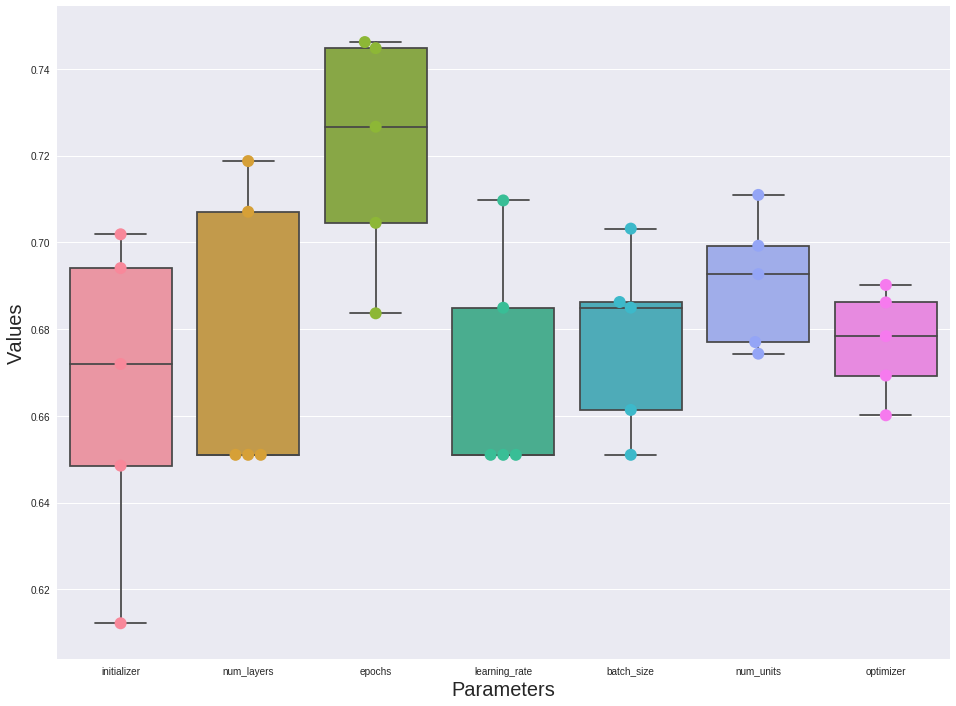

In [20]:
fig, ax = plt.subplots(figsize=(16, 12))
df_plot['value'] = df_plot['value'].astype(float)
sns.boxplot(x='parameter', y='value', data=df_plot, ax=ax)
sns.swarmplot(x='parameter', y='value', data=df_plot, size=12, ax=ax)
ax.set_xlabel('Parameters',size=20)
ax.set_ylabel('Values',size=20)

In [21]:
# Get the best parameter options
best_options = df_plot.groupby('parameter').apply(lambda grp: grp.nlargest(1, 'value'))[['parameter', 'option']].values.tolist()
best_options

[['batch_size', 4],
 ['epochs', 80],
 ['initializer', 'random_uniform'],
 ['learning_rate', 0.002],
 ['num_layers', 4],
 ['num_units', 64],
 ['optimizer', 'adamax']]

In [22]:
# Use the best_options to build a new baseline model
param_dict = get_defaults()

for i in best_options:
  if i[0] == 'num_units': # ensure num_units is a list
    param_dict[i[0]] = [i[1], 1]
  else:
    param_dict[i[0]] = i[1]

build_test_model(param_dict=param_dict)

Starting 3-fold cross-validation...
Finished cross-valiation. Took 2.5 mintues.
Mean Accuracy: 74.74%, Standard Deviation: 1.75%


0.7474338619107103

In [23]:
learning_rate = [0.00095, 0.001, 0.0018, 0.0019, 0.002, 0.003] #0.00095

tuning_options = get_tuning_options(learning_rate=learning_rate)

result = run_test(tuning_options, X, y, use_defaults=False, param_dict=param_dict)


Evaluating parameter "learning_rate" using value "0.00095"...
Starting 3-fold cross-validation...
Finished cross-valiation. Took 2.8 mintues.
Mean Accuracy: 74.21%, Standard Deviation: 1.75%

Evaluating parameter "learning_rate" using value "0.001"...
Starting 3-fold cross-validation...
Finished cross-valiation. Took 3.0 mintues.
Mean Accuracy: 76.18%, Standard Deviation: 3.30%

Evaluating parameter "learning_rate" using value "0.0018"...
Starting 3-fold cross-validation...
Finished cross-valiation. Took 3.0 mintues.
Mean Accuracy: 75.13%, Standard Deviation: 1.57%

Evaluating parameter "learning_rate" using value "0.0019"...
Starting 3-fold cross-validation...
Finished cross-valiation. Took 2.9 mintues.
Mean Accuracy: 74.48%, Standard Deviation: 1.69%

Evaluating parameter "learning_rate" using value "0.002"...
Starting 3-fold cross-validation...
Finished cross-valiation. Took 2.7 mintues.
Mean Accuracy: 74.75%, Standard Deviation: 2.34%

Evaluating parameter "learning_rate" using va

In [24]:
param_dict['learning_rate'] = 0.00095
param_dict

{'activation': 'relu',
 'activation_out': 'sigmoid',
 'batch_size': 4,
 'epochs': 80,
 'initializer': 'random_uniform',
 'input_dim': 8,
 'learning_rate': 0.00095,
 'loss': 'binary_crossentropy',
 'metrics': ['accuracy'],
 'num_layers': 4,
 'num_units': [64, 1],
 'one_hot': False,
 'optimizer': 'adamax'}

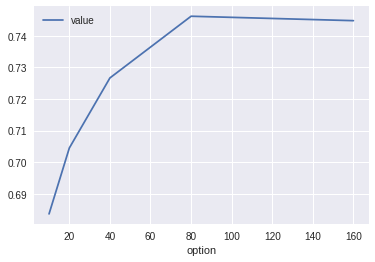

In [25]:
df_plot.query("parameter=='epochs'").plot(x='option', y='value')

In [26]:
epochs = [160, 180, 200, 220, 250] #0.00095

tuning_options = get_tuning_options(epochs=epochs)

result = run_test(tuning_options, X, y, use_defaults=False, param_dict=param_dict)


Evaluating parameter "epochs" using value "160"...
Starting 3-fold cross-validation...
Finished cross-valiation. Took 5.4 mintues.
Mean Accuracy: 77.09%, Standard Deviation: 3.04%

Evaluating parameter "epochs" using value "180"...
Starting 3-fold cross-validation...
Finished cross-valiation. Took 5.9 mintues.
Mean Accuracy: 75.66%, Standard Deviation: 1.85%

Evaluating parameter "epochs" using value "200"...
Starting 3-fold cross-validation...
Finished cross-valiation. Took 6.4 mintues.
Mean Accuracy: 75.53%, Standard Deviation: 1.95%

Evaluating parameter "epochs" using value "220"...
Starting 3-fold cross-validation...
Finished cross-valiation. Took 7.0 mintues.
Mean Accuracy: 76.57%, Standard Deviation: 4.67%

Evaluating parameter "epochs" using value "250"...
Starting 3-fold cross-validation...
Finished cross-valiation. Took 7.9 mintues.
Mean Accuracy: 78.92%, Standard Deviation: 4.69%


In [0]:
def visualize(result, param_tuned):
  """
  Visualizes the hyperparameter tuning result
  
  Params:
    result - dict, result dict returned by the run_test() func
    param_tuned - string, one of these:
      ['num_units', 'num_layers', 'loss', 'initializer', 'optimizer', 'learning_rate', 'epochs', 'batch_size']
  returns:
    None
  """

  d = result[param_tuned]

  xs, ys = np.array(list(d.keys())), np.array(list(d.values()))

  fig, ax = plt.subplots(figsize=(12, 8))
  plt.plot(xs, ys)  
  ax.set_xlim(xs.min()*0.9, xs.max()*1.1)
  plt.show()

In [28]:
visualize(result, 'learning_rate')

KeyError: ignored

In [0]:
# Now tune batch_size
batch_size = [1, 2, 4, 8, 16, 32, 64, 128] #4
tuning_options = {'batch_size': batch_size}
result = run_test(tuning_options, X, y)
visualize(result, 'batch_size')

1. params class
2. download pima from kaggle
3. reproducibility, random search
4. plot title
5. code refactoring: given param dict, test results
